In [ ]:
import nltk
import string
import re
from nltk.collocations import TrigramCollocationFinder
import math
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [1]:
languages = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']
trn_lst = {}
tst_lst = {}
for lang in languages:
    with open(f"./langId/{lang}_trn.txt", "r", encoding="utf-8") as llegir:
        trn_lst[lang] = llegir.read()
    with open(f"./langId/{lang}_tst.txt", "r", encoding="utf-8") as llegir:
        tst_lst[lang] = llegir.read()

deu_trn, eng_trn, fra_trn, ita_trn, nld_trn, spa_trn = trn_lst.values()
deu_tst, eng_tst, fra_tst, ita_tst, nld_tst, spa_tst = tst_lst.values()

In [2]:
def preprocessar(text):  
    text = text.lower()
    text = re.sub(r'(\d)\s+', r'\1', text) # remove spaces after numbers
    text = re.sub(r'\d+', ' ', text) # remove numbers
    text = re.sub(r'\t+', '', text) # remove tabs
    text = re.sub(r'\s[^\w\s]\s', ' ', text)
    text = re.sub(r' +', ' ', text) # remove multiple spaces
    text = re.sub(r'\n', '  ', text)
    text = re.sub(r'  +', '  ', text)

    return text

In [3]:
def trigrames(idioma, text):
    finder = TrigramCollocationFinder.from_words(text)
    finder.apply_freq_filter(5)
    return finder

In [4]:
train_preprocessed = {lang: trigrames(lang, preprocessar(trn_lst[lang])) for lang in trn_lst}
test_preprocessed = {lang: preprocessar(tst_lst[lang]).split('  ') for lang in tst_lst}

NameError: name 're' is not defined

In [ ]:
def predict_lang_in_sentences(sentences_list, finders, lamb=0.5):
    # Preprocess sentences by wrapping with spaces and pairing with empty lang
    sentences = [['  ' + sentence + '  ', ''] for sentence in sentences_list]
    # Remove the first and last elements (empty strings from splitting)
    sentences = sentences[1:-1]

    # Precompute total trigrams and unique trigrams count for each language
    total_trigrams = {lang: sum(finder.ngram_fd.values()) for lang, finder in finders.items()}
    different_trigrams = {lang: len(finder.ngram_fd) for lang, finder in finders.items()}

    # Process each sentence to determine its language
    for i in range(len(sentences)):
        sentence, _ = sentences[i]
        # Extract trigrams from the current sentence
        trigram_finder = TrigramCollocationFinder.from_words(sentence)
        trigram_finder.apply_freq_filter(1)  # Include all trigrams occurring at least once
        trigrams = trigram_finder.ngram_fd  # Trigram frequency distribution for the sentence

        max_log_likelihood = -math.inf
        best_lang = ''

        # Evaluate each language's model
        for lang in finders:
            lang_total = total_trigrams[lang]
            lang_unique = different_trigrams[lang]
            log_prob = 0.0

            for trigram, count in trigrams.items():
                freq_in_lang = finders[lang].ngram_fd.get(trigram, 0)
                probability = (freq_in_lang + lamb) / (lang_total + lamb * lang_unique)
                log_prob += count * math.log(probability)

            # Update the best language if current has higher likelihood
            if log_prob > max_log_likelihood:
                max_log_likelihood = log_prob
                best_lang = lang

        sentences[i][1] = best_lang  # Assign the detected language

    return sentences

In [ ]:
predictions = {lang: predict_lang_in_sentences(test_preprocessed[lang], train_preprocessed) for lang in languages}

In [ ]:
def evaluate_predictions(true_labels, predicted_labels, languages):
    f1 = f1_score(true_labels, predicted_labels, average='weighted', labels=languages)
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=languages)

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=languages)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.show()

    # Mostrar resultados
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")

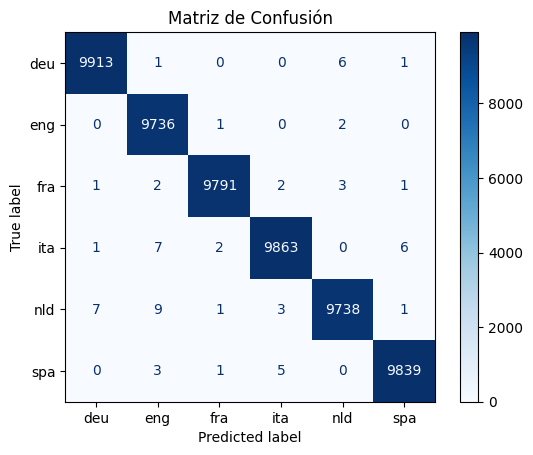

Accuracy: 0.9989
F1-score: 0.9989


In [ ]:
# Recolectar todas las etiquetas verdaderas y predichas
all_true_labels = []
all_predicted_labels = []

# Para cada idioma en el mismo orden que languages:
for lang in languages:
    # Etiquetas verdaderas: todas son el idioma actual (ej: 'deu' para deutsch)
    true_for_lang = [lang] * len(predictions[lang])
    # Etiquetas predichas: las obtenidas por el modelo
    predicted_for_lang = [pred_lang for (sentence, pred_lang) in predictions[lang]]
    
    all_true_labels.extend(true_for_lang)
    all_predicted_labels.extend(predicted_for_lang)

# Calcular les mètriques
evaluate_predictions(
    true_labels=all_true_labels,
    predicted_labels=all_predicted_labels,
    languages=languages
)